# Module 09: Decision Trees

## Prerequisites

In [2]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *
from matplotlib import pyplot as plt

# Modeling packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import partial_dependence

In [3]:
# Ames housing data
ames = pd.read_csv("../data/ames.csv")

# create train/test split
train, test = train_test_split(ames, train_size=0.7, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("Sale_Price", axis=1)
y_train = train[["Sale_Price"]]

## Basic implementation

### Simple model

In [4]:
# Step 1: create model object
dt_mod = DecisionTreeRegressor(max_depth=3)

# Step 2: fit/train model
dt_fit = dt_mod.fit(X_train[["Gr_Liv_Area", "Year_Built"]], y_train)

In [5]:
dt_fit.get_n_leaves()

8

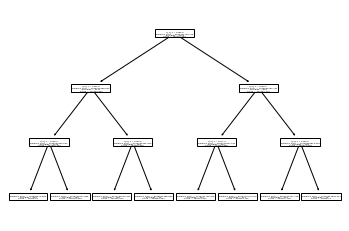

In [6]:
plot_tree(dt_fit)
plt.show()

### Cross-validated model

In [7]:
# create DT model object
dt_mod = DecisionTreeRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# fit model with 5-fold CV
results = cross_val_score(dt_mod, X_train[["Gr_Liv_Area", "Year_Built"]], 
                          y_train, cv=kfold, scoring=loss)


np.round(np.abs(results))

array([48741., 52220., 49789., 50335., 54185.])

### Full model

In [8]:
# create new feature set with encoded features
X_train_encoded = pd.get_dummies(X_train)

# fit model with 5-fold CV
results = cross_val_score(dt_mod, X_train_encoded, y_train, cv=kfold, scoring=loss)

np.abs(np.mean(results))

42106.373644834

## Tuning

In [9]:
# create model object
dt_mod = DecisionTreeRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 5 fold CV object
kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {
  'ccp_alpha': [1e-1, 1e-5, 1e-10],
  'max_depth': [1, 8, 15],
  'min_samples_split': [2, 21, 40]
  }

In [10]:
grid_search = GridSearchCV(dt_mod, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)

# Optimal penalty parameter in grid search
results.best_estimator_

DecisionTreeRegressor(ccp_alpha=1e-05, max_depth=15, min_samples_split=40)

In [11]:
# Best model's cross validated RMSE
round(abs(results.best_score_), 2)

37658.54

## Feature interpretation

### Feature importance

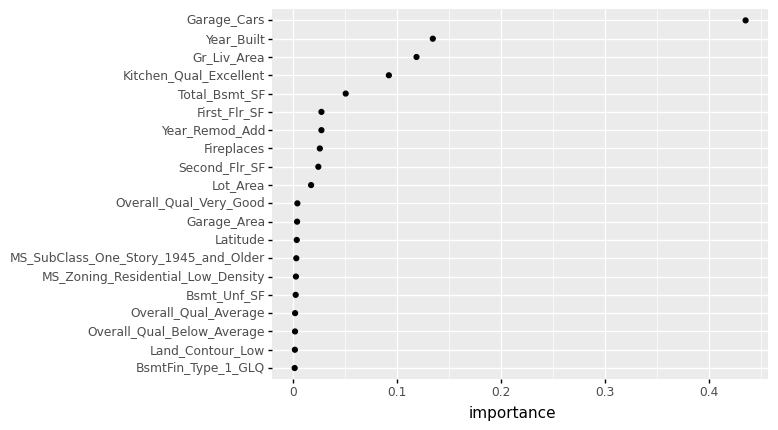

<ggplot: (17592021305043)>

In [12]:
# create final model object
best_mod = results.best_estimator_
best_mod_fit = best_mod.fit(X_train_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': X_train_encoded.columns,
                   'importance': best_mod_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

### Feature relationship

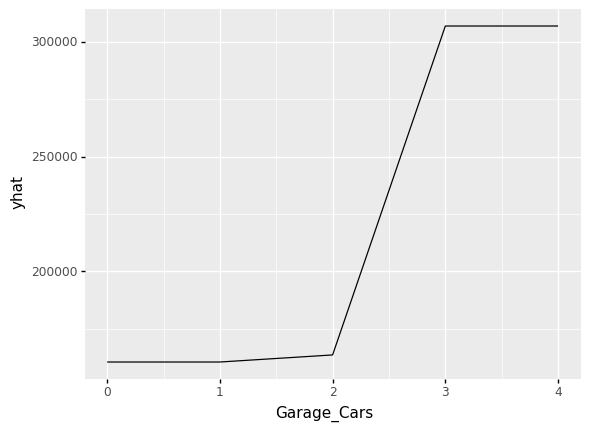

<ggplot: (17592021152202)>

In [13]:
pd_results = partial_dependence(
  best_mod_fit, X_train_encoded, "Garage_Cars", kind='average',
  percentiles=(0, 1)) 
  
pd_output = pd.DataFrame({'Garage_Cars': pd_results['values'][0],
                          'yhat': pd_results['average'][0]})
                          
(ggplot(pd_output, aes('Garage_Cars', 'yhat'))
  + geom_line())

## Exercises

Using the Boston housing data set, where the response feature is the median value of homes within a census tract (`cmedv`):

1. Apply a decision tree model with all features.
2. How many internal splitting nodes optimize model performance?
3. Can you identify the predicted values and SEE in the terminal nodes?
4. Identify the first feature split node and explain how it is splitting this feature.
5. Which 10 features are considered most influential? Are these the same features that have been influential in previous models?
6. Now perform 1-5 to the Attrition dataset, which is classification model rather than a regression model.